### Packages loading

In [2]:
import sys, qiskit
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import numpy as np
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state, random_circuit
from qsee.backend import constant, utilities
from qsee.evolution import crossover, mutate, selection, threshold
from qsee.evolution.environment import EEnvironment, EEnvironmentMetadata
%load_ext autoreload
%autoreload 2


## 1. Quantum architecture search for quantum state preparation problem

This is state preparation circuit which is generated by classical method (amplitude encoding)

Now, we defind the problem which is need to solve

In [3]:
num_qubits = 3
if num_qubits == 2:
    qc_haar = state.specific(np.array([0.73042448, -0.30956267, -0.45658101,  0.40272176]))

def compilation_fitness_w(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u=qc,
        target_state=state.w(num_qubits).inverse()
    ).fit(num_steps=10)
    return 1 - np.min(qsp.compiler.metrics['loss_fubini_study'])

def full_compilation_fitness_w(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u=qc,
        target_state=state.w(num_qubits).inverse()
    ).fit(num_steps=100)
    return 1 - np.min(qsp.compiler.metrics['loss_fubini_study'])

Main algorithm, includes: init population, selection, crossover, mutate.

In [9]:
env_metadata = EEnvironmentMetadata(
    num_qubits = num_qubits,
    depth = 5,
    num_circuit = 4,
    num_generation = 5,
    prob_mutate=3/(5 * 8)
)
env = EEnvironment(
    metadata = env_metadata,
    fitness_func=[compilation_fitness_w, full_compilation_fitness_w],
    selection_func=selection.elitist_selection,
    crossover_func=crossover.onepoint_crossover,
    mutate_func=mutate.layerflip_mutate,
    threshold_func=threshold.compilation_threshold
)

env.evol()

Initialize list of circuit ...
Start evol progress ...
Evol at generation 1
[0.2463422527433291, 0.18317688573351454, 0.18538352582334794, 0.2013135784301826]
Evol at generation 2
[0.2448841148538855, 0.23835703902681538, 0.18587470251809513, 0.4315811403551074]
Evol at generation 3
[0.43457980227091286, 0.24853476460983237, 0.40720998658884267, 0.24177839650930544]
Evol at generation 4
[0.43750555558299065, 0.4028400549266553, 0.20943058495790512, 0.4402679212337388]
Evol at generation 5
[0.2704796096064209, 0.30372419257883154, 0.4455633489748355, 0.43457980227091286]
End evol progress, best score ever: 0.4455633489748355


In [8]:
compilation_fitness_w(env.circuitss[1][0])

0.23292764356939566

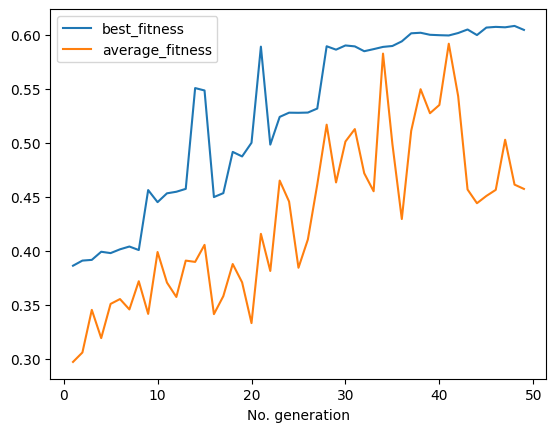

In [89]:
env.plot()

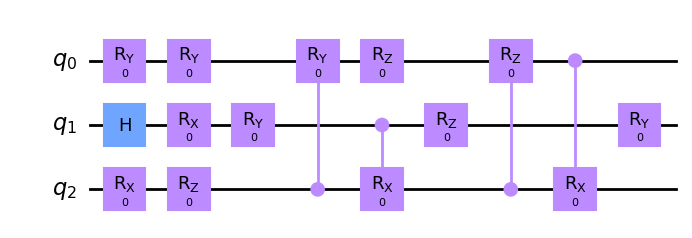

In [79]:
qc1 = random_circuit.generate_with_pool(3,3)
qc2 = random_circuit.generate_with_pool(3,3)
qc = utilities.compose_circuit([qc1, qc2])

qc = qc.assign_parameters([0]*(len(qc1.parameters) + len(qc2.parameters)))
import qiskit.quantum_info as qi
rho = qi.DensityMatrix(qc)
qc.draw('mpl')

In [52]:
env.save('test')

In [53]:
env2 = EEnvironment.load('./test', compilation_fitness_w)

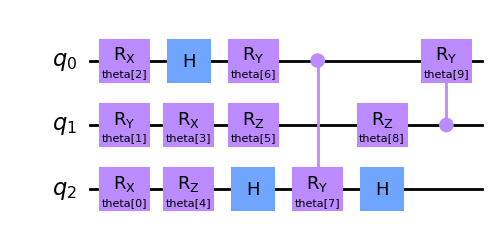

In [43]:
env2.circuits[1].draw('mpl')

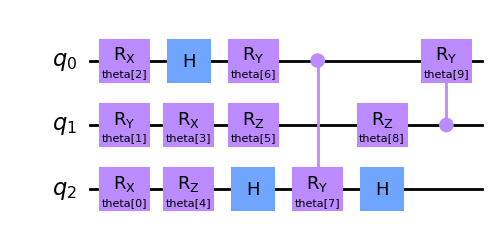

In [38]:
env2.circuitss[9][7].draw('mpl')

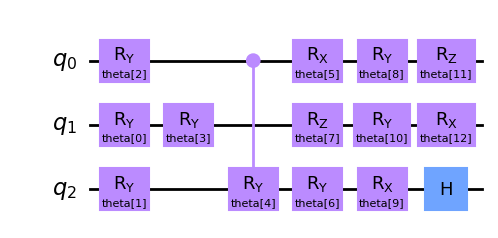

In [99]:
env.best_candidate.qc.draw('mpl')

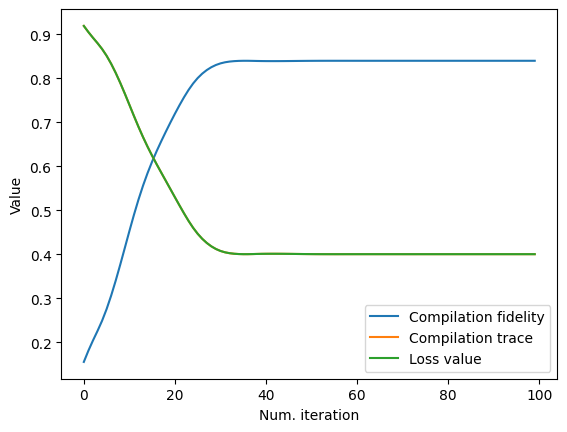

In [64]:
compiler = QuantumCompilation(
        u=env.best_candidate.qc,
        vdagger=state.w(num_qubits).inverse(),
        optimizer='adam',
        loss_func='loss_fubini_study'
    )
compiler.fit(num_steps=100, verbose=0)
compiler.plot(metrics = ['compilation'])